# 필수 실행


## 구글드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 필수 설치

In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.1 MB/s eta 0:00:00


## 필수 임포트

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.font_manager as fm

pd.set_option('display.max_columns', None)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

import warnings
warnings.filterwarnings('ignore')

## csv파일 불러오기


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/daegu/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/daegu/test.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/daegu/sample_submission.csv')
extra_train_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/countrywide_accident.csv')
light_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구보안등정보.csv',encoding='cp949')
child_area_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구어린이보호구역정보.csv',encoding='cp949')
parking_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구주차장정보.csv',encoding='cp949')
cctv_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구CCTV정보.csv',encoding='cp949')

## 콜백리스트

In [ ]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

## train/test data 합치기 및 컬럼정리


- 필요없다고 생각한 컬럼 정리

In [ ]:
light_df = light_df.drop(columns=['보안등위치명','소재지도로명주소','위도','경도'])
child_area_df = child_area_df.drop(columns=['소재지도로명주소','위도','경도','데이터기준일자'])
parking_df = parking_df.drop(columns=['주차장관리번호','소재지도로명주소','위도','경도','데이터기준일자'])
cctv_df = cctv_df.drop(columns=['소재지도로명주소','위도','경도'])

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

- 보안등 정보

In [ ]:
light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])

In [ ]:
light_df = pd.get_dummies(light_df, columns=['설치형태'])

In [ ]:
light_df['설치개수평균'] = light_df['설치개수']

light_ = light_df[['설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
                   '설치개수','도시', '구', '동']].groupby(['도시', '구', '동']).sum().reset_index()
light__ = light_df[['설치개수평균','도시', '구', '동']].groupby(['도시', '구', '동']).mean().round(2).reset_index()

In [ ]:
light_.reset_index(inplace=True, drop=True)
light__.reset_index(inplace=True, drop=True)

,설치개수,설치연도,도시,구,동,설치형태_건축물,설치형태_전용주,설치형태_한전주,설치개수평균
0,1,2016.0,대구광역시,남구,대명동,0,0,1,1


- 어린이 보호구역

In [ ]:
child_area_df['CCTV설치대수'].fillna(0, inplace=True)
child_area_df['CCTV설치한곳의수'] = 1
child_area_df['CCTV설치대수평균'] = child_area_df['CCTV설치대수']

In [ ]:
child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지'])

In [ ]:
child_area_df = pd.get_dummies(child_area_df, columns=['시설종류','관할경찰서명','CCTV설치여부'])

In [ ]:
child_area_ = child_area_df[['시설종류_어린이집',
       '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교', '시설종류_학원', '관할경찰서명_강북경찰서',
       '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서', '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서',
       '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서', '관할경찰서명_수성경찰서', 'CCTV설치여부_N',
       'CCTV설치여부_Y','CCTV설치한곳의수','CCTV설치대수','도시', '구', '동']].groupby(['도시', '구', '동']).sum().reset_index()
child_area__ = child_area_df[['CCTV설치대수평균','도시', '구', '동']].groupby(['도시', '구', '동']).mean().round(2).reset_index()

In [ ]:
child_area_.reset_index(inplace=True, drop=True)
child_area__.reset_index(inplace=True, drop=True)

,대상시설명,관리기관명,CCTV설치대수,보호구역도로폭,CCTV설치한곳의수,CCTV설치대수평균,도시,구,동,시설종류_어린이집,시설종류_유치원,시설종류_초등학교,시설종류_특수학교,시설종류_학원,관할경찰서명_강북경찰서,관할경찰서명_남부경찰서,관할경찰서명_달성경찰서,관할경찰서명_대구광역시 중부경찰서,관할경찰서명_대구동부경찰서,관할경찰서명_북부경찰서,관할경찰서명_서부경찰서,관할경찰서명_수성경찰서,CCTV설치여부_N,CCTV설치여부_Y
0,남도초등학교,대구광역시,7.0,6~8,1,7.0,대구광역시,남구,대명동,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1


- 주차장 정보

In [ ]:
parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지'])

parking_df['주차구획수평균'] = parking_df['주차구획수']
parking_df = pd.get_dummies(parking_df, columns=['급지구분','결제방법','주차장구분','주차장유형'])


parking_df_ = parking_df[['급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외','주차구획수','도시', '구', '동']].groupby(['도시', '구', '동']).sum().reset_index()
parking_df__ = parking_df[['주차구획수평균','주차기본요금','추가단위요금',
                           '1일주차권요금','월정기권요금','도시', '구', '동']].groupby(['도시', '구', '동']).mean().round(2).reset_index()


parking_df_.reset_index(inplace=True, drop=True)
parking_df__.reset_index(inplace=True, drop=True)

- cctv 정보

In [ ]:
cctv_df['무인CCTV설치한곳의수'] = 1

In [ ]:
cctv_df[['도시', '구', '동', '번지']] = cctv_df['소재지지번주소'].str.extract(location_pattern)
cctv_df = cctv_df.drop(columns=['소재지지번주소', '번지'])

In [ ]:
cctv_df = pd.get_dummies(cctv_df, columns=['도로노선방향'])

In [ ]:
cctv_ = cctv_df[['도로노선방향_1', '도로노선방향_2','도로노선방향_3',
                 '무인CCTV설치한곳의수','도시', '구', '동']].groupby(['도시', '구', '동']).sum().reset_index()
cctv__ = cctv_df[['설치연도','제한속도','도시', '구', '동']].groupby(['도시', '구', '동']).mean().round(2).reset_index()

In [ ]:
cctv_.reset_index(inplace=True, drop=True)
cctv__.reset_index(inplace=True, drop=True)

cctv_df.head(1)

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,설치장소,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도,무인CCTV설치한곳의수,도시,구,동,도로노선방향_1,도로노선방향_2,도로노선방향_3
0,주차12,대구광역시,남구,시도,NaN,대명로,안지랑네거리1 버스정류장,4,0,NaN,NaN,99.0,2010.0,1,대구광역시,남구,대명동,0,0,1


- '사고일시' 분리

In [ ]:
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_df['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
train_df = train_df.drop(columns=['사고일시'])

test_df[['연', '월', '일', '시간']] = test_df['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

- '시군구' 분리

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_df['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_df['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

- '도로형태'분리

In [ ]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_df['도로형태'].str.extract(road_pattern)

test_df[['도로형태1', '도로형태2']] = test_df['도로형태'].str.extract(road_pattern)

- 추가정보들 일단 모두 merge하기

In [ ]:
print(f'{light_df.shape}/{child_area_df.shape}/{parking_df.shape}/{cctv_df.shape}')

(71913, 9)/(640, 24)/(871, 39)/(1065, 20)


In [ ]:
parking_df.columns

Index(['주차장명', '주차구획수', '부제시행구분', '운영요일', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각',
       '토요일운영종료시각', '공휴일운영시작시각', '공휴일운영종료시각', '요금정보', '주차기본시간', '주차기본요금',
       '추가단위시간', '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금', '특기사항', '도시',
       '구', '동', '주차구획수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드',
       '결제방법_무료', '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금',
       '결제방법_현금+신용카드', '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영',
       '주차장유형_노상', '주차장유형_노외'],
      dtype='object')

In [ ]:
train_df = train_df.drop(columns=['사고유형 - 세부분류', '법규위반',
                                  '가해운전자 차종', '가해운전자 성별','가해운전자 연령', '가해운전자 상해정도',
                                  '피해운전자 차종','피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도',
                                  '사망자수', '중상자수', '경상자수', '부상자수',])

In [ ]:
train_df = pd.merge(train_df, light_, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, light__, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, light_, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, light__, how='left', on=['도시', '구', '동'])

In [ ]:
train_df = pd.merge(train_df, child_area_, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, child_area__, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, child_area_, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, child_area__, how='left', on=['도시', '구', '동'])

In [ ]:
train_df = pd.merge(train_df, parking_df_, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, parking_df__, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, parking_df_, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, parking_df__, how='left', on=['도시', '구', '동'])

In [ ]:
train_df = pd.merge(train_df, cctv_, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, cctv__, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, cctv_, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, cctv__, how='left', on=['도시', '구', '동'])

- train_df에서 test_df에 없는 컬럼 삭제하기

In [ ]:
print(f"{train_df.shape} / {test_df.shape}")

(39609, 67) / (10963, 66)


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 67 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  39609 non-null  object 
 1   요일                  39609 non-null  object 
 2   기상상태                39609 non-null  object 
 3   도로형태                39609 non-null  object 
 4   노면상태                39609 non-null  object 
 5   사고유형                39609 non-null  object 
 6   ECLO                39609 non-null  int64  
 7   연                   39609 non-null  int64  
 8   월                   39609 non-null  int64  
 9   일                   39609 non-null  int64  
 10  시간                  39609 non-null  int64  
 11  도시                  39609 non-null  object 
 12  구                   39609 non-null  object 
 13  동                   39609 non-null  object 
 14  도로형태1               39609 non-null  object 
 15  도로형태2               39609 non-null  object 
 16  설치형태

# Model_1 [0.42862]
> ['요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2']

- base model

In [ ]:
test_x = test_df[['요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2',
                  '연','월','일','시간','설치개수','cnt','급지구분_1','급지구분_2','급지구분_3']].copy()
train_x = train_df[['요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2',
                    '연','월','일','시간','설치개수','cnt','급지구분_1','급지구분_2','급지구분_3']].copy()
train_y = train_df['ECLO'].copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder

categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

for i in categorical_features:
    le = TargetEncoder(cols=[i])
    train_x[i] = le.fit_transform(train_x[i], train_y)
    test_x[i] = le.transform(test_x[i])

display(train_x.head())
display(test_x.head())

['요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2']

,요일,기상상태,노면상태,사고유형,도시,구,동,도로형태1,도로형태2,연,월,일,시간,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3
0,4.627926,4.712888,4.712878,3.817650,4.726704,4.541610,4.282449,4.671841,4.599599,2019,1,1,0,391.0,2.0,11.0,0.0,0.0
1,4.627926,4.779150,4.712878,3.817650,4.726704,4.618441,4.738938,4.671841,4.599599,2019,1,1,0,932.0,NaN,0.0,1.0,3.0
2,4.627926,4.712888,4.712878,3.817650,4.726704,4.727300,4.842715,4.671841,4.599599,2019,1,1,1,473.0,5.0,NaN,NaN,NaN
3,4.627926,4.712888,4.712878,4.944597,4.726704,4.687669,4.208920,4.671841,4.599599,2019,1,1,2,534.0,11.0,0.0,9.0,5.0
4,4.627926,4.712888,4.712878,4.944597,4.726704,4.889534,4.549091,4.671841,4.599599,2019,1,1,4,2057.0,NaN,0.0,1.0,0.0


,요일,기상상태,노면상태,사고유형,도시,구,동,도로형태1,도로형태2,연,월,일,시간,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3
0,4.920811,4.712888,4.712878,3.817650,4.726704,4.727300,4.881657,4.882281,5.006142,2022,1,1,1,700.0,5.0,NaN,NaN,NaN
1,4.920811,4.712888,4.712878,3.817650,4.726704,4.727300,4.563008,4.671841,4.599599,2022,1,1,1,NaN,10.0,0.0,0.0,2.0
2,4.920811,4.712888,4.712878,4.944597,4.726704,4.727300,4.945578,4.882281,5.006142,2022,1,1,4,NaN,1.0,NaN,NaN,NaN
3,4.920811,4.712888,4.712878,4.944597,4.726704,4.727300,4.438172,4.671841,4.599599,2022,1,1,4,NaN,7.0,0.0,2.0,1.0
4,4.920811,4.712888,4.712878,4.944597,4.726704,4.618441,4.738938,4.882281,5.006142,2022,1,1,6,932.0,NaN,0.0,1.0,3.0


In [ ]:
train_x.fillna(0, inplace=True)
test_x.fillna(0, inplace=True)

In [ ]:
import tensorflow as tf

def rmsle(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    squared_error = tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))

    return tf.sqrt(tf.reduce_mean(squared_error))

def loss_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

def metric_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

In [ ]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

In [ ]:
def create_model():

    input_layer = tf.keras.Input(shape=(len(train_x.columns), ))
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(input_layer)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    output_layer = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=loss_fn,
                  metrics=[metric_fn]
                  )

    return model

model = create_model()
history = model.fit(train_x.astype('float32'), train_y.astype('float32'),
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_split=0.1)

Epoch 1/100


1114/1114 [==============================] - 6s 4ms/step - loss: 0.5167 - metric_fn: 0.5167 - val_loss: 0.4351 - val_metric_fn: 0.4351 - lr: 0.0010
Epoch 2/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.4482 - metric_fn: 0.4482 - val_loss: 0.4290 - val_metric_fn: 0.4290 - lr: 0.0010
Epoch 3/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.4447 - metric_fn: 0.4447 - val_loss: 0.4289 - val_metric_fn: 0.4289 - lr: 0.0010
Epoch 4/100
1114/1114 [==============================] - 5s 4ms/step - loss: 0.4428 - metric_fn: 0.4428 - val_loss: 0.4269 - val_metric_fn: 0.4268 - lr: 0.0010
Epoch 5/100
1114/1114 [==============================] - 4s 4ms/step - loss: 0.4425 - metric_fn: 0.4425 - val_loss: 0.4252 - val_metric_fn: 0.4252 - lr: 0.0010
Epoch 6/100
1114/1114 [==============================] - 4s 3ms/step - loss: 0.4418 - metric_fn: 0.4418 - val_loss: 0.4241 - val_metric_fn: 0.4240 - lr: 0.0010
Epoch 7/100
1114/1114 [=============================

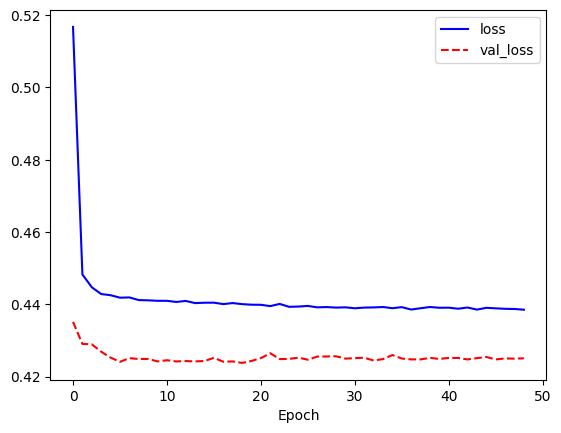

In [ ]:
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

343/343 [==============================] - 1s 2ms/step


<Axes: ylabel='Count'>

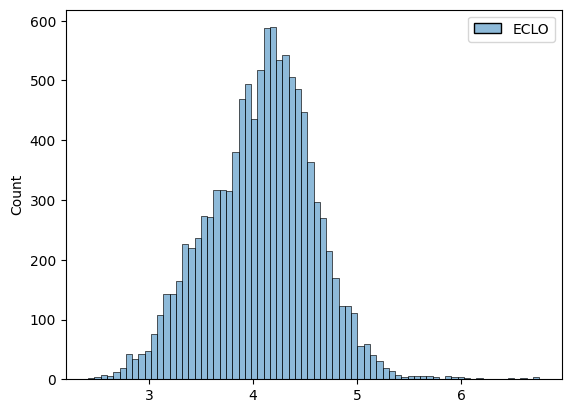

In [ ]:
sample_submission = submission_df.copy()

sample_submission["ECLO"] = model.predict(test_x.astype('float32'))

sns.histplot(sample_submission)

# Model_2 [0.42793]
> ['주차구획수'] 추가

- base model
- 수아님꺼

In [ ]:
test_x = test_df[['요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2',
                  '연','월','일','시간','설치개수','cnt','급지구분_1','급지구분_2','급지구분_3','주차구획수']].copy()
train_x = train_df[['요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2',
                    '연','월','일','시간','설치개수','cnt','급지구분_1','급지구분_2','급지구분_3','주차구획수']].copy()
train_y = train_df['ECLO'].copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder

categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

for i in categorical_features:
    le = TargetEncoder(cols=[i])
    train_x[i] = le.fit_transform(train_x[i], train_y)
    test_x[i] = le.transform(test_x[i])

display(train_x.head())
display(test_x.head())

['요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2']

,요일,기상상태,노면상태,사고유형,도시,구,동,도로형태1,도로형태2,연,월,일,시간,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3,주차구획수
0,4.627926,4.712888,4.712878,3.817650,4.726704,4.541610,4.282449,4.671841,4.599599,2019,1,1,0,391.0,2.0,11.0,0.0,0.0,500.0
1,4.627926,4.779150,4.712878,3.817650,4.726704,4.618441,4.738938,4.671841,4.599599,2019,1,1,0,932.0,NaN,0.0,1.0,3.0,114.0
2,4.627926,4.712888,4.712878,3.817650,4.726704,4.727300,4.842715,4.671841,4.599599,2019,1,1,1,473.0,5.0,NaN,NaN,NaN,NaN
3,4.627926,4.712888,4.712878,4.944597,4.726704,4.687669,4.208920,4.671841,4.599599,2019,1,1,2,534.0,11.0,0.0,9.0,5.0,374.0
4,4.627926,4.712888,4.712878,4.944597,4.726704,4.889534,4.549091,4.671841,4.599599,2019,1,1,4,2057.0,NaN,0.0,1.0,0.0,63.0


,요일,기상상태,노면상태,사고유형,도시,구,동,도로형태1,도로형태2,연,월,일,시간,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3,주차구획수
0,4.920811,4.712888,4.712878,3.817650,4.726704,4.727300,4.881657,4.882281,5.006142,2022,1,1,1,700.0,5.0,NaN,NaN,NaN,NaN
1,4.920811,4.712888,4.712878,3.817650,4.726704,4.727300,4.563008,4.671841,4.599599,2022,1,1,1,NaN,10.0,0.0,0.0,2.0,183.0
2,4.920811,4.712888,4.712878,4.944597,4.726704,4.727300,4.945578,4.882281,5.006142,2022,1,1,4,NaN,1.0,NaN,NaN,NaN,NaN
3,4.920811,4.712888,4.712878,4.944597,4.726704,4.727300,4.438172,4.671841,4.599599,2022,1,1,4,NaN,7.0,0.0,2.0,1.0,153.0
4,4.920811,4.712888,4.712878,4.944597,4.726704,4.618441,4.738938,4.882281,5.006142,2022,1,1,6,932.0,NaN,0.0,1.0,3.0,114.0


In [ ]:
train_x.fillna(0, inplace=True)
test_x.fillna(0, inplace=True)

In [ ]:
import tensorflow as tf

def rmsle(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    squared_error = tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))

    return tf.sqrt(tf.reduce_mean(squared_error))

def loss_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

def metric_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

In [ ]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

In [ ]:
def create_model():

    input_layer = tf.keras.Input(shape=(len(train_x.columns), ))
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(input_layer)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    output_layer = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=loss_fn,
                  metrics=[metric_fn]
                  )

    return model

model = create_model()
history = model.fit(train_x.astype('float32'), train_y.astype('float32'),
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_split=0.1)

Epoch 1/100
1114/1114 [==============================] - 5s 3ms/step - loss: 0.5116 - metric_fn: 0.5116 - val_loss: 0.4324 - val_metric_fn: 0.4323 - lr: 0.0010
Epoch 2/100
1114/1114 [==============================] - 7s 6ms/step - loss: 0.4470 - metric_fn: 0.4470 - val_loss: 0.4276 - val_metric_fn: 0.4276 - lr: 0.0010
Epoch 3/100
1114/1114 [==============================] - 4s 3ms/step - loss: 0.4442 - metric_fn: 0.4442 - val_loss: 0.4241 - val_metric_fn: 0.4240 - lr: 0.0010
Epoch 4/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.4428 - metric_fn: 0.4428 - val_loss: 0.4248 - val_metric_fn: 0.4248 - lr: 0.0010
Epoch 5/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.4425 - metric_fn: 0.4425 - val_loss: 0.4241 - val_metric_fn: 0.4240 - lr: 0.0010
Epoch 6/100
1114/1114 [==============================] - 5s 5ms/step - loss: 0.4423 - metric_fn: 0.4423 - val_loss: 0.4247 - val_metric_fn: 0.4246 - lr: 0.0010
Epoch 7/100
1114/1114 [=================

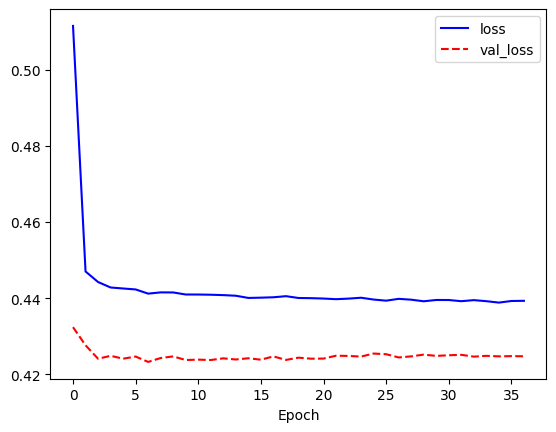

In [ ]:
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

343/343 [==============================] - 2s 4ms/step


<Axes: ylabel='Count'>

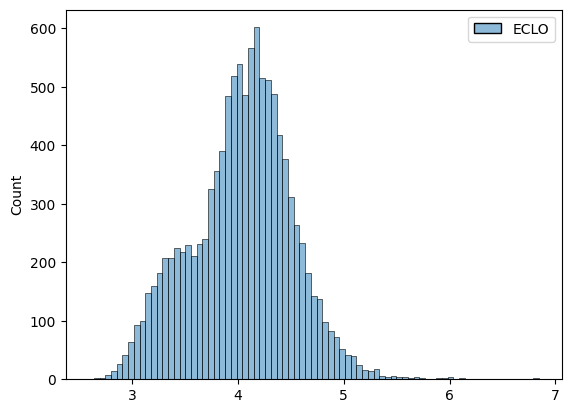

In [ ]:
sample_submission = submission_df.copy()

sample_submission["ECLO"] = model.predict(test_x.astype('float32'))

sns.histplot(sample_submission)

# Model_4 []


In [ ]:
train_df.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
       '설치개수', '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교',
       '시설종류_학원', '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
       '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서',
       '관할경찰서명_수성경찰서', 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수',
       'CCTV설치대수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도'],
      dtype='object')

In [ ]:
test_x = test_df[['요일', '노면상태', '사고유형', '기상상태','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','동','설치개수','설치개수평균','주차구획수',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_x = train_df[['요일', '노면상태', '사고유형', '기상상태','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','동','설치개수','설치개수평균','주차구획수',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_y = train_df['ECLO'].copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder

categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

for i in categorical_features:
    le = TargetEncoder(cols=[i])
    train_x[i] = le.fit_transform(train_x[i], train_y)
    test_x[i] = le.transform(test_x[i])

display(train_x.head())
display(test_x.head())

['요일', '노면상태', '사고유형', '기상상태', '도로형태2', '동']

,요일,노면상태,사고유형,기상상태,도로형태2,설치형태_건축물,설치형태_전용주,설치형태_한전주,시간,동,설치개수,설치개수평균,주차구획수,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도
0,4.627926,4.712878,3.817650,4.712888,4.599599,177.0,30.0,135.0,0,4.282449,391.0,1.00,500.0,0.0,0.0,1136.36,2013.00,8.0
1,4.627926,4.712878,3.817650,4.779150,4.599599,0.0,0.0,0.0,0,4.738938,932.0,1.00,114.0,NaN,NaN,150.00,2015.33,17.5
2,4.627926,4.712878,3.817650,4.712888,4.599599,14.0,31.0,425.0,1,4.842715,473.0,1.00,NaN,0.0,0.0,NaN,2018.25,55.0
3,4.627926,4.712878,4.944597,4.712888,4.599599,0.0,0.0,0.0,2,4.208920,534.0,1.00,374.0,0.0,2.0,71.43,2018.30,38.0
4,4.627926,4.712878,4.944597,4.712888,4.599599,540.0,57.0,1396.0,4,4.549091,2057.0,1.03,63.0,NaN,NaN,600.00,2018.25,40.0


,요일,노면상태,사고유형,기상상태,도로형태2,설치형태_건축물,설치형태_전용주,설치형태_한전주,시간,동,설치개수,설치개수평균,주차구획수,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도
0,4.920811,4.712878,3.817650,4.712888,5.006142,104.0,16.0,579.0,1,4.881657,700.0,1.0,NaN,0.0,0.0,NaN,2020.00,52.50
1,4.920811,4.712878,3.817650,4.712888,4.599599,NaN,NaN,NaN,1,4.563008,NaN,NaN,183.0,0.0,0.0,700.00,2019.14,47.14
2,4.920811,4.712878,4.944597,4.712888,5.006142,NaN,NaN,NaN,4,4.945578,NaN,NaN,NaN,0.0,0.0,NaN,2020.00,40.00
3,4.920811,4.712878,4.944597,4.712888,4.599599,NaN,NaN,NaN,4,4.438172,NaN,NaN,153.0,0.0,0.0,333.33,2019.73,42.73
4,4.920811,4.712878,4.944597,4.712888,5.006142,0.0,0.0,0.0,6,4.738938,932.0,1.0,114.0,NaN,NaN,150.00,2015.33,17.50


In [ ]:
train_x.fillna(0, inplace=True)
test_x.fillna(0, inplace=True)

In [ ]:
import tensorflow as tf

def rmsle(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    squared_error = tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))

    return tf.sqrt(tf.reduce_mean(squared_error))

def loss_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

def metric_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

In [ ]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

In [ ]:
def create_model():

    input_layer = tf.keras.Input(shape=(len(train_x.columns), ))
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(input_layer)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    output_layer = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=loss_fn,
                  metrics=[metric_fn]
                  )

    return model

model = create_model()
history = model.fit(train_x.astype('float32'), train_y.astype('float32'),
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_split=0.1)

Epoch 1/100
1114/1114 [==============================] - 5s 3ms/step - loss: 0.4802 - metric_fn: 0.4802 - val_loss: 0.4314 - val_metric_fn: 0.4314 - lr: 0.0010
Epoch 2/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.4470 - metric_fn: 0.4470 - val_loss: 0.4286 - val_metric_fn: 0.4286 - lr: 0.0010
Epoch 3/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.4450 - metric_fn: 0.4450 - val_loss: 0.4251 - val_metric_fn: 0.4251 - lr: 0.0010
Epoch 4/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.4440 - metric_fn: 0.4440 - val_loss: 0.4247 - val_metric_fn: 0.4247 - lr: 0.0010
Epoch 5/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.4433 - metric_fn: 0.4433 - val_loss: 0.4241 - val_metric_fn: 0.4241 - lr: 0.0010
Epoch 6/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.4423 - metric_fn: 0.4423 - val_loss: 0.4239 - val_metric_fn: 0.4239 - lr: 0.0010
Epoch 7/100
1114/1114 [=================

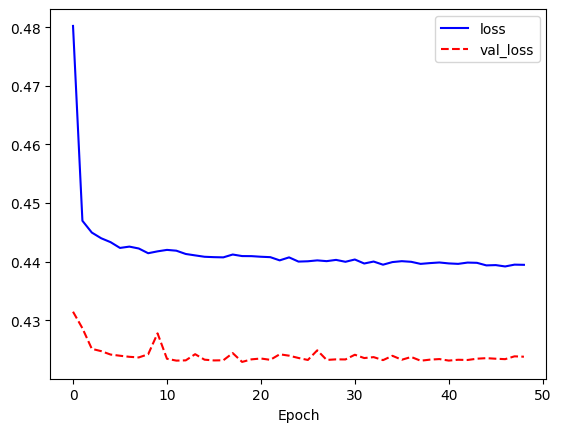

In [ ]:
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

343/343 [==============================] - 1s 1ms/step


<Axes: ylabel='Count'>

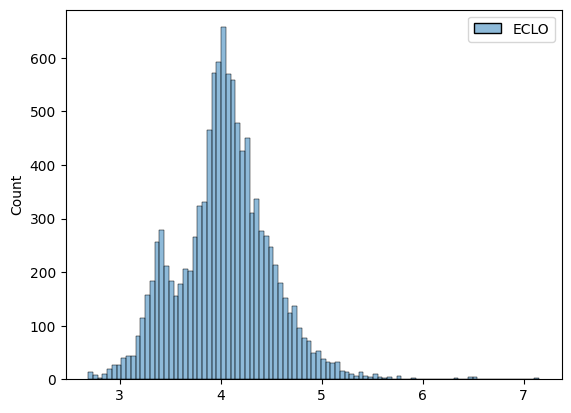

In [ ]:
sample_submission = submission_df.copy()

sample_submission["ECLO"] = model.predict(test_x.astype('float32'))

sns.histplot(sample_submission)

# Model_3 [0.42898]

In [ ]:
train_df.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치개수', '설치개수평균', 'CCTV설치한곳의수',
       'CCTV설치대수', 'CCTV설치대수평균', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금',
       '1일주차권요금', '월정기권요금', '무인CCTV설치한곳의수', '설치연도', '제한속도'],
      dtype='object')

In [ ]:
test_x = test_df[['요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간',
                  '도시', '구', '동', '도로형태1', '도로형태2', '설치개수', '설치개수평균', 'CCTV설치한곳의수',
                  'CCTV설치대수', 'CCTV설치대수평균', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금',
                  '1일주차권요금', '월정기권요금', '무인CCTV설치한곳의수', '설치연도', '제한속도']].copy()
train_x = train_df[['요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간',
                    '도시', '구', '동', '도로형태1', '도로형태2', '설치개수', '설치개수평균', 'CCTV설치한곳의수',
                    'CCTV설치대수', 'CCTV설치대수평균', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금',
                    '1일주차권요금', '월정기권요금', '무인CCTV설치한곳의수', '설치연도', '제한속도']].copy()
train_y = train_df['ECLO'].copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder

categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

for i in categorical_features:
    le = TargetEncoder(cols=[i])
    train_x[i] = le.fit_transform(train_x[i], train_y)
    test_x[i] = le.transform(test_x[i])

display(train_x.head())
display(test_x.head())

['요일', '기상상태', '도로형태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2']

,요일,기상상태,도로형태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,설치개수평균,CCTV설치한곳의수,CCTV설치대수,CCTV설치대수평균,주차구획수,주차구획수평균,주차기본요금,추가단위요금,1일주차권요금,월정기권요금,무인CCTV설치한곳의수,설치연도,제한속도
0,4.627926,4.712888,4.65399,4.712878,3.817650,2019,1,1,0,4.726704,4.541610,4.282449,4.671841,4.599599,391.0,1.00,2.0,13.0,6.50,500.0,45.45,1136.36,1100.0,NaN,NaN,5.0,2013.00,8.0
1,4.627926,4.779150,4.65399,4.712878,3.817650,2019,1,1,0,4.726704,4.618441,4.738938,4.671841,4.599599,932.0,1.00,NaN,NaN,NaN,114.0,28.50,150.00,200.0,NaN,80000.0,12.0,2015.33,17.5
2,4.627926,4.712888,4.65399,4.712878,3.817650,2019,1,1,1,4.726704,4.727300,4.842715,4.671841,4.599599,473.0,1.00,5.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2018.25,55.0
3,4.627926,4.712888,4.65399,4.712878,4.944597,2019,1,1,2,4.726704,4.687669,4.208920,4.671841,4.599599,534.0,1.00,11.0,32.0,2.91,374.0,26.71,71.43,2000.0,10000.0,NaN,10.0,2018.30,38.0
4,4.627926,4.712888,4.65399,4.712878,4.944597,2019,1,1,4,4.726704,4.889534,4.549091,4.671841,4.599599,2057.0,1.03,NaN,NaN,NaN,63.0,63.00,600.00,300.0,6000.0,80000.0,12.0,2018.25,40.0


,요일,기상상태,도로형태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,설치개수평균,CCTV설치한곳의수,CCTV설치대수,CCTV설치대수평균,주차구획수,주차구획수평균,주차기본요금,추가단위요금,1일주차권요금,월정기권요금,무인CCTV설치한곳의수,설치연도,제한속도
0,4.920811,4.712888,5.006142,4.712878,3.817650,2022,1,1,1,4.726704,4.727300,4.881657,4.882281,5.006142,700.0,1.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2020.00,52.50
1,4.920811,4.712888,4.653990,4.712878,3.817650,2022,1,1,1,4.726704,4.727300,4.563008,4.671841,4.599599,NaN,NaN,10.0,0.0,0.0,183.0,91.5,700.00,1100.00,2000.00,20000.0,7.0,2019.14,47.14
2,4.920811,4.712888,5.006142,4.712878,4.944597,2022,1,1,4,4.726704,4.727300,4.945578,4.882281,5.006142,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2020.00,40.00
3,4.920811,4.712888,4.653990,4.712878,4.944597,2022,1,1,4,4.726704,4.727300,4.438172,4.671841,4.599599,NaN,NaN,7.0,0.0,0.0,153.0,51.0,333.33,166.67,3333.33,20000.0,11.0,2019.73,42.73
4,4.920811,4.712888,5.006142,4.712878,4.944597,2022,1,1,6,4.726704,4.618441,4.738938,4.882281,5.006142,932.0,1.0,NaN,NaN,NaN,114.0,28.5,150.00,200.00,NaN,80000.0,12.0,2015.33,17.50


In [ ]:
train_x.fillna(0, inplace=True)
test_x.fillna(0, inplace=True)

In [ ]:
import tensorflow as tf

def rmsle(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    squared_error = tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))

    return tf.sqrt(tf.reduce_mean(squared_error))

def loss_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

def metric_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

In [ ]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

In [ ]:
def create_model():

    input_layer = tf.keras.Input(shape=(len(train_x.columns), ))
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(input_layer)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    output_layer = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=loss_fn,
                  metrics=[metric_fn]
                  )

    return model

model = create_model()
history = model.fit(train_x.astype('float32'), train_y.astype('float32'),
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_split=0.1)

Epoch 1/100
1114/1114 [==============================] - 5s 3ms/step - loss: 0.5252 - metric_fn: 0.5252 - val_loss: 0.4418 - val_metric_fn: 0.4417 - lr: 0.0010
Epoch 2/100
1114/1114 [==============================] - 4s 3ms/step - loss: 0.4501 - metric_fn: 0.4501 - val_loss: 0.4310 - val_metric_fn: 0.4310 - lr: 0.0010
Epoch 3/100
1114/1114 [==============================] - 4s 3ms/step - loss: 0.4457 - metric_fn: 0.4457 - val_loss: 0.4282 - val_metric_fn: 0.4281 - lr: 0.0010
Epoch 4/100
1114/1114 [==============================] - 4s 3ms/step - loss: 0.4443 - metric_fn: 0.4443 - val_loss: 0.4275 - val_metric_fn: 0.4274 - lr: 0.0010
Epoch 5/100
1114/1114 [==============================] - 4s 3ms/step - loss: 0.4429 - metric_fn: 0.4429 - val_loss: 0.4251 - val_metric_fn: 0.4251 - lr: 0.0010
Epoch 6/100
1114/1114 [==============================] - 4s 3ms/step - loss: 0.4427 - metric_fn: 0.4427 - val_loss: 0.4241 - val_metric_fn: 0.4241 - lr: 0.0010
Epoch 7/100
1114/1114 [=================

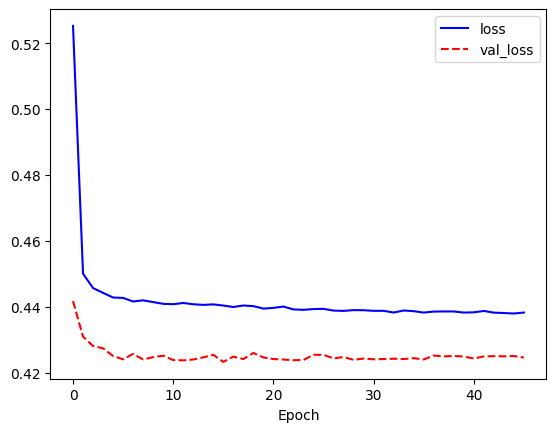

In [ ]:
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

343/343 [==============================] - 1s 2ms/step


<Axes: ylabel='Count'>

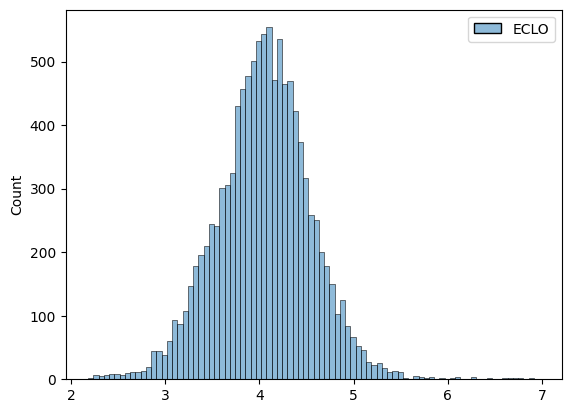

In [ ]:
sample_submission = submission_df.copy()

sample_submission["ECLO"] = model.predict(test_x.astype('float32'))

sns.histplot(sample_submission)

In [ ]:
sample_submission.to_csv('/content/drive/MyDrive/[Tensorflow]컬럼추가.csv', index=False)

# Model_5 []

In [ ]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [ ]:
for i in  ['동']:
  _ant =  (train.groupby([i])['ECLO'].mean() < 4).astype(int)
  train = pd.merge(train, _ant, how='left', on=[i])
  test = pd.merge(test, _ant, how='left', on=[i])

  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)
  test.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

  train = train.drop(columns=[i])
  test = test.drop(columns=[i])

In [ ]:
test.rename(columns={'ECLO':'new동'}, inplace=True)

In [ ]:
test_x = test[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도','new동',
                   '설치형태_한전주','설치개수', '주차구획수', '주차구획수평균', '제한속도']].copy()
train_x = train[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도','new동',
                   '설치형태_한전주','설치개수', '주차구획수', '주차구획수평균', '제한속도']].copy()
train_y = train['ECLO'].copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder

categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

for i in categorical_features:
    le = TargetEncoder(cols=[i])
    train_x[i] = le.fit_transform(train_x[i], train_y)
    test_x[i] = le.transform(test_x[i])

display(train_x.head())
display(test_x.head())

['요일', '노면상태', '사고유형', '도로형태2']

,요일,노면상태,사고유형,도로형태2,설치형태_건축물,설치형태_전용주,시간,설치개수평균,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,new동,설치형태_한전주,설치개수,주차구획수,주차구획수평균,제한속도
0,4.627926,4.712878,3.817650,4.599599,177.0,30.0,0,1.00,0.0,0.0,1136.36,2013.00,0,135.0,391.0,500.0,45.45,8.0
1,4.627926,4.712878,3.817650,4.599599,0.0,0.0,0,1.00,0.0,0.0,150.00,2015.33,0,0.0,932.0,114.0,28.50,17.5
2,4.627926,4.712878,3.817650,4.599599,14.0,31.0,1,1.00,0.0,0.0,0.00,2018.25,0,425.0,473.0,0.0,0.00,55.0
3,4.627926,4.712878,4.944597,4.599599,0.0,0.0,2,1.00,0.0,2.0,71.43,2018.30,0,0.0,534.0,374.0,26.71,38.0
4,4.627926,4.712878,4.944597,4.599599,540.0,57.0,4,1.03,0.0,0.0,600.00,2018.25,0,1396.0,2057.0,63.0,63.00,40.0


,요일,노면상태,사고유형,도로형태2,설치형태_건축물,설치형태_전용주,시간,설치개수평균,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,new동,설치형태_한전주,설치개수,주차구획수,주차구획수평균,제한속도
0,4.920811,4.712878,3.817650,5.006142,104.0,16.0,1,1.0,0.0,0.0,0.00,2020.00,0,579.0,700.0,0.0,0.0,52.50
1,4.920811,4.712878,3.817650,4.599599,0.0,0.0,1,0.0,0.0,0.0,700.00,2019.14,0,0.0,0.0,183.0,91.5,47.14
2,4.920811,4.712878,4.944597,5.006142,0.0,0.0,4,0.0,0.0,0.0,0.00,2020.00,0,0.0,0.0,0.0,0.0,40.00
3,4.920811,4.712878,4.944597,4.599599,0.0,0.0,4,0.0,0.0,0.0,333.33,2019.73,0,0.0,0.0,153.0,51.0,42.73
4,4.920811,4.712878,4.944597,5.006142,0.0,0.0,6,1.0,0.0,0.0,150.00,2015.33,0,0.0,932.0,114.0,28.5,17.50


In [ ]:
train_x.fillna(0, inplace=True)
test_x.fillna(0, inplace=True)

In [ ]:
import tensorflow as tf

def rmsle(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    squared_error = tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))

    return tf.sqrt(tf.reduce_mean(squared_error))

def loss_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

def metric_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

In [ ]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

In [ ]:
def create_model():

    input_layer = tf.keras.Input(shape=(len(train_x.columns), ))
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(input_layer)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    output_layer = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=loss_fn,
                  metrics=[metric_fn]
                  )

    return model

model = create_model()
history = model.fit(train_x.astype('float32'), train_y.astype('float32'),
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_split=0.1)

Epoch 1/100
1114/1114 [==============================] - 5s 3ms/step - loss: 0.5143 - metric_fn: 0.5143 - val_loss: 0.4350 - val_metric_fn: 0.4349 - lr: 0.0010
Epoch 2/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.4488 - metric_fn: 0.4488 - val_loss: 0.4276 - val_metric_fn: 0.4276 - lr: 0.0010
Epoch 3/100
1114/1114 [==============================] - 4s 3ms/step - loss: 0.4459 - metric_fn: 0.4459 - val_loss: 0.4278 - val_metric_fn: 0.4277 - lr: 0.0010
Epoch 4/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.4452 - metric_fn: 0.4452 - val_loss: 0.4258 - val_metric_fn: 0.4257 - lr: 0.0010
Epoch 5/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.4442 - metric_fn: 0.4442 - val_loss: 0.4260 - val_metric_fn: 0.4259 - lr: 0.0010
Epoch 6/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.4440 - metric_fn: 0.4440 - val_loss: 0.4262 - val_metric_fn: 0.4262 - lr: 0.0010
Epoch 7/100
1114/1114 [=================

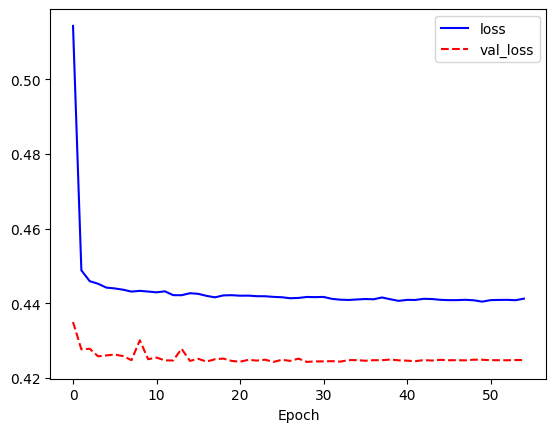

In [ ]:
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

343/343 [==============================] - 1s 1ms/step


<Axes: ylabel='Count'>

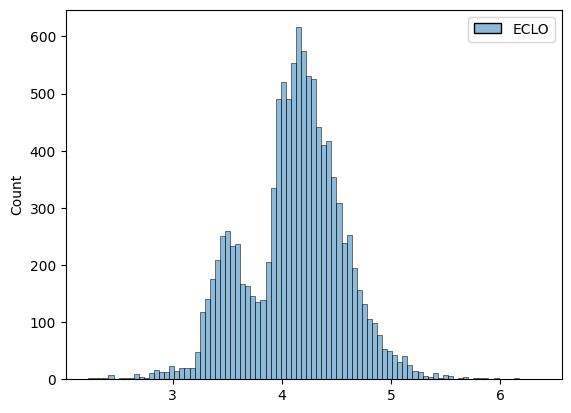

In [ ]:
sample_submission = submission_df.copy()

sample_submission["ECLO"] = model.predict(test_x.astype('float32'))

sns.histplot(sample_submission)

In [ ]:
sample_submission.to_csv('/content/drive/MyDrive/[Tensorflow]stacking에서좋았던컬럼.csv', index=False)

# Model_6 []

In [ ]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [ ]:
test_x = test[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도',
                   '설치형태_한전주','설치개수', '주차구획수', '주차구획수평균', '제한속도']].copy()
train_x = train[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도',
                   '설치형태_한전주','설치개수', '주차구획수', '주차구획수평균', '제한속도']].copy()
train_y = train['ECLO'].copy()

In [ ]:
def time_range(time):
  if time >= 0 and time <= 7 :
    return 1
  elif time <= 12 :
    return 2
  elif time <= 18 :
    return 3
  else :
    return 4

train_x['time_range'] = train_x['시간'].apply(time_range)
test_x['time_range'] = test_x['시간'].apply(time_range)

In [ ]:
def time_carBycar(data):
  if data['사고유형'] == '차대차':
    if data['time_range'] == 1:
      return 1
    elif data['time_range'] == 4:
      return 1
    else:
      return 2
  elif data['사고유형'] == '차대사람' and data['time_range'] == 3:
    return 0
  else:
    return 2


train_x['time_carBycar_data'] = train_x.apply(time_carBycar, axis = 1)
test_x['time_carBycar_data'] = test_x.apply(time_carBycar, axis = 1)
train_x.head()

## ECLOO 평균이 5 이상인 차대차 이면서 새벽과 늦은저녁인 행은 1
## ECLO가 가장 낮은 오후이면서 차대 사람이면 행은 2
## 나머지는 3으로

,요일,노면상태,사고유형,도로형태2,설치형태_건축물,설치형태_전용주,시간,설치개수평균,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,설치형태_한전주,설치개수,주차구획수,주차구획수평균,제한속도,time_range,time_carBycar_data
0,화요일,건조,차대사람,기타,177.0,30.0,0,1.00,0.0,0.0,1136.36,2013.00,135.0,391.0,500.0,45.45,8.0,1,2
1,화요일,건조,차대사람,기타,0.0,0.0,0,1.00,0.0,0.0,150.00,2015.33,0.0,932.0,114.0,28.50,17.5,1,2
2,화요일,건조,차대사람,기타,14.0,31.0,1,1.00,0.0,0.0,0.00,2018.25,425.0,473.0,0.0,0.00,55.0,1,2
3,화요일,건조,차대차,기타,0.0,0.0,2,1.00,0.0,2.0,71.43,2018.30,0.0,534.0,374.0,26.71,38.0,1,1
4,화요일,건조,차대차,기타,540.0,57.0,4,1.03,0.0,0.0,600.00,2018.25,1396.0,2057.0,63.0,63.00,40.0,1,1


In [ ]:
def time_road(data):
  if data['도로형태2'] == '터널':
    return 1
  elif data['도로형태2'] == '고가도로위':
    if data['time_range'] == 1 or data['time_range'] == 4:
      return 1
    else:
      return 0
  elif data['도로형태2'] == '주차장':
    return 2
  elif data['도로형태2'] == '미분류':
    return 2
  else :
    return 0

train_x['time_road_data'] = train_x.apply(time_road, axis = 1)
test_x['time_road_data'] = test_x.apply(time_road, axis = 1)
train_x.head()

,요일,노면상태,사고유형,도로형태2,설치형태_건축물,설치형태_전용주,시간,설치개수평균,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,설치형태_한전주,설치개수,주차구획수,주차구획수평균,제한속도,time_range,time_carBycar_data,time_road_data
0,화요일,건조,차대사람,기타,177.0,30.0,0,1.00,0.0,0.0,1136.36,2013.00,135.0,391.0,500.0,45.45,8.0,1,2,0
1,화요일,건조,차대사람,기타,0.0,0.0,0,1.00,0.0,0.0,150.00,2015.33,0.0,932.0,114.0,28.50,17.5,1,2,0
2,화요일,건조,차대사람,기타,14.0,31.0,1,1.00,0.0,0.0,0.00,2018.25,425.0,473.0,0.0,0.00,55.0,1,2,0
3,화요일,건조,차대차,기타,0.0,0.0,2,1.00,0.0,2.0,71.43,2018.30,0.0,534.0,374.0,26.71,38.0,1,1,0
4,화요일,건조,차대차,기타,540.0,57.0,4,1.03,0.0,0.0,600.00,2018.25,1396.0,2057.0,63.0,63.00,40.0,1,1,0


In [ ]:
def sun_time_acci(data):
  if data['요일'] == '일요일':
    if data['time_range'] == 2 or data['time_range'] == 3:
      return 1
    else:
      return 0
  else:
    return 0

train_x['sun_timed_data'] = train_x.apply(sun_time_acci, axis = 1)
test_x['sun_timed_data'] = test_x.apply(sun_time_acci, axis = 1)
train_x.head()

,요일,노면상태,사고유형,도로형태2,설치형태_건축물,설치형태_전용주,시간,설치개수평균,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,설치형태_한전주,설치개수,주차구획수,주차구획수평균,제한속도,time_range,time_carBycar_data,time_road_data,sun_timed_data
0,화요일,건조,차대사람,기타,177.0,30.0,0,1.00,0.0,0.0,1136.36,2013.00,135.0,391.0,500.0,45.45,8.0,1,2,0,0
1,화요일,건조,차대사람,기타,0.0,0.0,0,1.00,0.0,0.0,150.00,2015.33,0.0,932.0,114.0,28.50,17.5,1,2,0,0
2,화요일,건조,차대사람,기타,14.0,31.0,1,1.00,0.0,0.0,0.00,2018.25,425.0,473.0,0.0,0.00,55.0,1,2,0,0
3,화요일,건조,차대차,기타,0.0,0.0,2,1.00,0.0,2.0,71.43,2018.30,0.0,534.0,374.0,26.71,38.0,1,1,0,0
4,화요일,건조,차대차,기타,540.0,57.0,4,1.03,0.0,0.0,600.00,2018.25,1396.0,2057.0,63.0,63.00,40.0,1,1,0,0


In [ ]:
def day_carBy(data):
  if data['사고유형'] == '차대차':
    if data['요일'] == '일요일':
      return 1
    elif data['요일'] == '토요일':
      return 1
    else :
      return 0
  elif data['사고유형'] == '차량단독':
    if data['요일'] == '수요일':
      return 2
    else:
      return 0
  elif data['사고유형'] == '차대사람' and data['요일'] == '목요일':
    return 2
  else:
    return 0

train_x['day_carBy_data'] = train_x.apply(day_carBy, axis = 1)
test_x['day_carBy_data'] = test_x.apply(day_carBy, axis = 1)
train_x.head()

,요일,노면상태,사고유형,도로형태2,설치형태_건축물,설치형태_전용주,시간,설치개수평균,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,설치형태_한전주,설치개수,주차구획수,주차구획수평균,제한속도,time_range,time_carBycar_data,time_road_data,sun_timed_data,day_carBy_data
0,화요일,건조,차대사람,기타,177.0,30.0,0,1.00,0.0,0.0,1136.36,2013.00,135.0,391.0,500.0,45.45,8.0,1,2,0,0,0
1,화요일,건조,차대사람,기타,0.0,0.0,0,1.00,0.0,0.0,150.00,2015.33,0.0,932.0,114.0,28.50,17.5,1,2,0,0,0
2,화요일,건조,차대사람,기타,14.0,31.0,1,1.00,0.0,0.0,0.00,2018.25,425.0,473.0,0.0,0.00,55.0,1,2,0,0,0
3,화요일,건조,차대차,기타,0.0,0.0,2,1.00,0.0,2.0,71.43,2018.30,0.0,534.0,374.0,26.71,38.0,1,1,0,0,0
4,화요일,건조,차대차,기타,540.0,57.0,4,1.03,0.0,0.0,600.00,2018.25,1396.0,2057.0,63.0,63.00,40.0,1,1,0,0,0


In [ ]:
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder

categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

for i in categorical_features:
    le = TargetEncoder(cols=[i])
    train_x[i] = le.fit_transform(train_x[i], train_y)
    test_x[i] = le.transform(test_x[i])

display(train_x.head())
display(test_x.head())

['요일', '노면상태', '사고유형', '도로형태2']

,요일,노면상태,사고유형,도로형태2,설치형태_건축물,설치형태_전용주,시간,설치개수평균,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,설치형태_한전주,설치개수,주차구획수,주차구획수평균,제한속도,time_range,time_carBycar_data,time_road_data,sun_timed_data,day_carBy_data
0,4.627926,4.712878,3.817650,4.599599,177.0,30.0,0,1.00,0.0,0.0,1136.36,2013.00,135.0,391.0,500.0,45.45,8.0,1,2,0,0,0
1,4.627926,4.712878,3.817650,4.599599,0.0,0.0,0,1.00,0.0,0.0,150.00,2015.33,0.0,932.0,114.0,28.50,17.5,1,2,0,0,0
2,4.627926,4.712878,3.817650,4.599599,14.0,31.0,1,1.00,0.0,0.0,0.00,2018.25,425.0,473.0,0.0,0.00,55.0,1,2,0,0,0
3,4.627926,4.712878,4.944597,4.599599,0.0,0.0,2,1.00,0.0,2.0,71.43,2018.30,0.0,534.0,374.0,26.71,38.0,1,1,0,0,0
4,4.627926,4.712878,4.944597,4.599599,540.0,57.0,4,1.03,0.0,0.0,600.00,2018.25,1396.0,2057.0,63.0,63.00,40.0,1,1,0,0,0


,요일,노면상태,사고유형,도로형태2,설치형태_건축물,설치형태_전용주,시간,설치개수평균,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,설치형태_한전주,설치개수,주차구획수,주차구획수평균,제한속도,time_range,time_carBycar_data,time_road_data,sun_timed_data,day_carBy_data
0,4.920811,4.712878,3.817650,5.006142,104.0,16.0,1,1.0,0.0,0.0,0.00,2020.00,579.0,700.0,0.0,0.0,52.50,1,2,0,0,0
1,4.920811,4.712878,3.817650,4.599599,0.0,0.0,1,0.0,0.0,0.0,700.00,2019.14,0.0,0.0,183.0,91.5,47.14,1,2,0,0,0
2,4.920811,4.712878,4.944597,5.006142,0.0,0.0,4,0.0,0.0,0.0,0.00,2020.00,0.0,0.0,0.0,0.0,40.00,1,1,0,0,1
3,4.920811,4.712878,4.944597,4.599599,0.0,0.0,4,0.0,0.0,0.0,333.33,2019.73,0.0,0.0,153.0,51.0,42.73,1,1,0,0,1
4,4.920811,4.712878,4.944597,5.006142,0.0,0.0,6,1.0,0.0,0.0,150.00,2015.33,0.0,932.0,114.0,28.5,17.50,1,1,0,0,1


In [ ]:
train_x.fillna(0, inplace=True)
test_x.fillna(0, inplace=True)

In [ ]:
import tensorflow as tf

def rmsle(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    squared_error = tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))

    return tf.sqrt(tf.reduce_mean(squared_error))

def loss_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

def metric_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

In [ ]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

In [ ]:
def create_model():

    input_layer = tf.keras.Input(shape=(len(train_x.columns), ))
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(input_layer)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    output_layer = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=loss_fn,
                  metrics=[metric_fn]
                  )

    return model

model = create_model()
history = model.fit(train_x.astype('float32'), train_y.astype('float32'),
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_split=0.1)

Epoch 1/100


1114/1114 [==============================] - 5s 3ms/step - loss: 0.5219 - metric_fn: 0.5219 - val_loss: 0.4348 - val_metric_fn: 0.4348 - lr: 0.0010
Epoch 2/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.4511 - metric_fn: 0.4511 - val_loss: 0.4311 - val_metric_fn: 0.4311 - lr: 0.0010
Epoch 3/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.4474 - metric_fn: 0.4474 - val_loss: 0.4280 - val_metric_fn: 0.4280 - lr: 0.0010
Epoch 4/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.4461 - metric_fn: 0.4461 - val_loss: 0.4269 - val_metric_fn: 0.4268 - lr: 0.0010
Epoch 5/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.4448 - metric_fn: 0.4448 - val_loss: 0.4255 - val_metric_fn: 0.4254 - lr: 0.0010
Epoch 6/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.4445 - metric_fn: 0.4445 - val_loss: 0.4266 - val_metric_fn: 0.4266 - lr: 0.0010
Epoch 7/100
1114/1114 [=============================

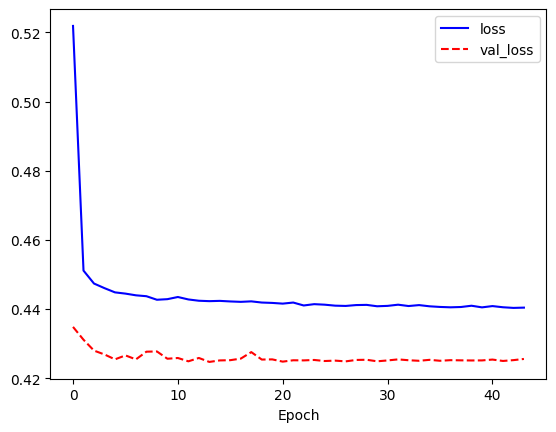

In [ ]:
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

343/343 [==============================] - 1s 2ms/step


<Axes: ylabel='Count'>

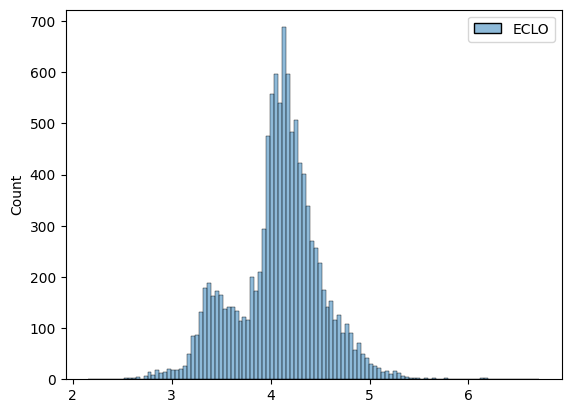

In [ ]:
sample_submission = submission_df.copy()

sample_submission["ECLO"] = model.predict(test_x.astype('float32'))

sns.histplot(sample_submission)